# Introduction

In a prior notebook, documents were partitioned by assigning them to the domain with the highest Dice similarity of their term and structure occurrences. The occurrences of terms and structures in each domain is what we refer to as the domain "archetype." Here, we'll assess whether the observed similarity between documents and the archetype is greater than expected by chance. This would indicate that information in the framework generalizes well to individual documents.

# Load the data

In [1]:
import sys
sys.path.append("..")
import utilities, archetype
import pandas as pd
import numpy as np

In [2]:
framework = "data-driven" 
version = 190325 # Document-term matrix version
list_suffix = "_nn" # Suffix for term lists
n_iter = 1000 # Iterations for null distribution
dx = [0.39, 0.38, 0.37, 0.39, 0.39, 0.38] # Nudges for plotted means
ds = 0.11 # Nudges for plotted stars
alpha = 0.001 # Significance level for statistical comparisons

## Brain activation coordinates

In [3]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=114


## Document-term matrix

In [4]:
dtm_bin = utilities.load_doc_term_matrix(version=version, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Domain archetypes

In [8]:
from collections import OrderedDict

In [9]:
lists, circuits = utilities.load_framework(framework, suffix=utilities.suffix[framework], circuit_suffix="_nn")

In [10]:
words = sorted(list(set(lists["TOKEN"])))
structures = sorted(list(set(act_bin.columns)))
domains = list(OrderedDict.fromkeys(lists["DOMAIN"]))

In [11]:
archetypes = pd.DataFrame(0.0, index=words+structures, columns=domains)
for dom in domains:
    for word in lists.loc[lists["DOMAIN"] == dom, "TOKEN"]:
        archetypes.loc[word, dom] = 1.0
    for struct in structures:
        archetypes.loc[struct, dom] = circuits.loc[struct, dom]
archetypes[archetypes > 0.0] = 1.0
print("Term & Structure N={}, Domain N={}".format(
      archetypes.shape[0], archetypes.shape[1]))

Term & Structure N=175, Domain N=6


## Document structure-term vectors

In [12]:
pmids = dtm_bin.index.intersection(act_bin.index)
len(pmids)

18155

In [13]:
dtm_words = dtm_bin.loc[pmids, words]
act_structs = act_bin.loc[pmids, structures]

In [14]:
docs = dtm_words.copy()
docs[structures] = act_structs.copy()
docs.head()

,action,anticipation,arousal,attention,cognitive_control,decision_making,declarative_memory,emotion,emotional_memory,encoding,...,right_superior_temporal_gyrus_posterior_division,right_supplementary_motor_cortex,right_supracalcarine_cortex,right_supramarginal_gyrus_anterior_division,right_supramarginal_gyrus_posterior_division,right_temporal_fusiform_cortex_anterior_division,right_temporal_fusiform_cortex_posterior_division,right_temporal_occipital_fusiform_cortex,right_temporal_pole,right_thalamus
10022492,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,1
10022494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,0,0,0,1,0,0
10022496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
10027301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
10051677,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,1,1


## Document assignments

In [15]:
doc2dom_df = pd.read_csv("../partition/data/doc2dom_{}_nn.csv".format(framework), 
                         header=None, index_col=0)
doc2dom = {int(pmid): int(dom) for pmid, dom in doc2dom_df.iterrows()}

In [16]:
dom2docs = {dom: [] for dom in domains}
for doc, dom in doc2dom.items():
    dom2docs[domains[dom-1]].append(doc)

# Compute similarity to archetype

In [17]:
from scipy.spatial.distance import cdist

## Observed values

In [18]:
df_obs = pd.DataFrame(index=domains, columns=pmids)
for dom in domains:
    dom_pmids = dom2docs[dom]
    dom_vecs = docs.loc[dom_pmids].values
    dom_arche = archetypes[dom].values.reshape(1, archetypes.shape[0])
    dom_sims = 1.0 - cdist(dom_vecs, dom_arche, metric="dice")
    df_obs.loc[dom, dom_pmids] = dom_sims[:,0]
df = pd.DataFrame({"OBSERVED": df_obs.mean(axis=1)}, index=domains)
df.to_csv("data/arche_obs_{}_nn.csv".format(framework))
df.head(8)

,OBSERVED
MEMORY,0.332722
REWARD,0.323826
REACTION_TIME,0.363608
MANIPULATION,0.426669
VISION,0.385986
LANGUAGE,0.416164


## Null distributions

In [21]:
import os

In [22]:
file_null = "data/arche_null_{}_nn_{}iter.csv".format(framework, n_iter)
if not os.path.isfile(file_null):
    df_null = np.zeros((len(domains), n_iter))
    for n in range(n_iter):
        null = np.random.choice(range(len(docs.columns)), 
                                size=len(docs.columns), replace=False)
        for i, dom in enumerate(domains):
            dom_pmids = dom2docs[dom]
            dom_vecs = docs.loc[dom_pmids].values
            dom_arche = archetypes.values[null,i].reshape(1, archetypes.shape[0])
            df_null[i,n] = 1.0 - np.mean(cdist(dom_vecs, dom_arche, metric="dice"))
        if n % int(n_iter / 10.0) == 0:
            print("Processed {} iterations".format(n))
    df_null = pd.DataFrame(df_null, index=domains, columns=range(n_iter))
    df_null.to_csv(file_null)
else:
    df_null = pd.read_csv(file_null, index_col=0, header=0)

Processed 0 iterations
Processed 100 iterations
Processed 200 iterations
Processed 300 iterations
Processed 400 iterations
Processed 500 iterations
Processed 600 iterations
Processed 700 iterations
Processed 800 iterations
Processed 900 iterations


## Bootstrap distributions

In [23]:
file_boot = "data/arche_boot_{}_nn_{}iter.csv".format(framework, n_iter)
if not os.path.isfile(file_boot):
    df_boot = np.zeros((len(domains), n_iter))
    for n in range(n_iter):
        boot = np.random.choice(range(len(docs.columns)), 
                                size=len(docs.columns), replace=True)
        for i, dom in enumerate(domains):
            dom_pmids = dom2docs[dom]
            dom_vecs = docs.loc[dom_pmids].values[:,boot]
            dom_arche = archetypes.values[boot,i].reshape(1, archetypes.shape[0])
            df_boot[i,n] = 1.0 - np.mean(cdist(dom_vecs, dom_arche, metric="dice"))
        if n % int(n_iter / 10.0) == 0:
            print("Processed {} iterations".format(n))
    df_boot = pd.DataFrame(df_boot, index=domains, columns=range(n_iter))
    df_boot.to_csv(file_boot)
else:
    df_boot = pd.read_csv(file_boot, index_col=0, header=0)

Processed 0 iterations
Processed 100 iterations
Processed 200 iterations
Processed 300 iterations
Processed 400 iterations
Processed 500 iterations
Processed 600 iterations
Processed 700 iterations
Processed 800 iterations
Processed 900 iterations


# Perform significance testing

In [24]:
from statsmodels.stats import multitest

In [25]:
pval = []
for dom in domains:   
    dom_null = df_null.loc[dom].values
    dom_obs = float(df.loc[dom, "OBSERVED"])
    p = np.sum(dom_null >= dom_obs) / float(n_iter)
    pval.append(p)
    df.loc[dom, "P"] = p
df["FDR"] = multitest.multipletests(pval, method="fdr_bh")[1]
for dom in domains:
    if df.loc[dom, "FDR"] < alpha:
        df.loc[dom, "STARS"] = "*"
    else:
        df.loc[dom, "STARS"] = ""
df = df.loc[domains, ["OBSERVED", "P", "FDR", "STARS"]]
df

,OBSERVED,P,FDR,STARS
MEMORY,0.332722,0.0,0.0,*
REWARD,0.323826,0.0,0.0,*
REACTION_TIME,0.363608,0.0,0.0,*
MANIPULATION,0.426669,0.0,0.0,*
VISION,0.385986,0.0,0.0,*
LANGUAGE,0.416164,0.0,0.0,*


# Plot results

In [26]:
%matplotlib inline

In [27]:
palette = utilities.palettes[framework]

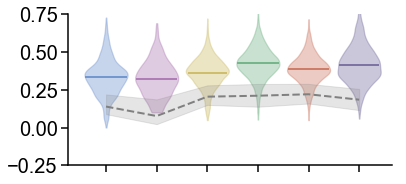

In [29]:
archetype.plot_violins(framework, domains, df, df_null, df_obs, palette, 
                       dx=dx, ds=ds, alphas=[0], interval=0.999,
                       ylim=[-0.25,0.75], yticks=[-0.25,0,0.25,0.5,0.75], 
                       suffix="_nn")